In [220]:
using Plots
using Random
using Distributions
using LinearAlgebra
include("pogm_restart.jl") # issues adding MIRT so will use julia file instead
rng = Random.seed!(0)
N = 500
D = 100
d = 10
σ1 = 0
σ2 = 0
goodpts = 10

σ1_features = 2
σ2_features = 35
goodpts_features = 50

X = zeros(D,N)
Y = zeros(D,N)
Π = vec(zeros(N,1))
W = vec(zeros(D,1))
U1 = svd(rand(D,N)).U[:,1:d]
for k = 1:N
    X[:,k] = U1*U1'*rand(Uniform(-100,100),D)
end
for j=1:D
        if (j<= goodpts_features)
            Y[j,:] = Y[j,:] + rand(Normal(0,σ1_features),N)
            W[j] = σ1_features^2
        else
            Y[j,:] = Y[j,:] + rand(Normal(0,σ2_features),N)
            W[j] = σ2_features^2
        end
end

In [224]:
using HePPCAT
heppCAT_matrix = []
push!(heppCAT_matrix, Y[:,1:goodpts])
push!(heppCAT_matrix, Y[:,(goodpts+1):end])
homoPCA = heppcat(heppCAT_matrix,d,0)
error_homoppca = norm(homoPCA.U*homoPCA.U' - U1*U1', 2)/norm(U1*U1', 2)

1.3371009195704244

In [225]:
using Arpack
function HeteroPCA(Σ,r,T)
    N = Σ - Diagonal(Σ)
    for t in 1:T
        U,λ,V = svds(N,nsv=r)[1]
        Nt = U[:,1:r]*Diagonal(λ[1:r])*V[:,1:r]'
        N = N - Diagonal(N) + Diagonal(Nt)
    end
    U,λ,_ = svds(N,nsv=r)[1]
    return U
end

HeteroPCA (generic function with 1 method)

In [230]:
U_heteropca = HeteroPCA(Y*Y', 10, 1000);
error_heteropca = norm(U_heteropca*U_heteropca' - U1*U1', 2)/norm(U1*U1', 2)

1.3359618523085728

In [219]:
# function HPCA_POGM(Y, λr, w,feature, N, rank, ϵ)
#     #objective = (X,Z,λr,Π) -> λr*nucnorm(X) + (1/2)*norm(Z*(Diagonal(Π.^-0.5)), 2)
#     Π = w.^-1
#     W = feature.^-1
#     lipMatrix = unique(W)*unique(Π)'
#     Lf = minimum(vec(lipMatrix))
#     Π = Diagonal(Π)
#     W = Diagonal(W)
#     x0 = zeros(size(Y))
#     grad = K -> -1*W*(Y-K)*Π
#     soft = (x,t) -> sign.(x) .* max.(abs.(x) .- t, 0)
#     function pssvt(x,t,N)
#         U,S,V = svd(x)
#         S[(N+1):end] = soft.(S[(N+1):end],t)
#         return U*diagm(S)*V'
#     end
#     prox1 = (z,c) -> pssvt(z, c*λr, N)
#     W, _ = pogm_restart(x0, x -> 0, grad, Lf ; g_prox=prox1, eps=ϵ) # objective(x,Y-x,λr,w)
#     U = svd(W).U[:,1:rank]
#     return U
# end

function FEATURE_HPCA(Y, λr, w,features, N, μ, ρ, d)
    #X = zeros(size(Y))
    #Z = zeros(size(Y))
    U_svd = svd(Y).U[:,1:N]
    X = deepcopy(U_svd*U_svd'*Y)
    #X0 = zeros(size(Y)) .+ 1
    Z = deepcopy(Y-X)
    Π = Diagonal(w.^-1)
    W = Diagonal(features.^-1)
    #Λ = zeros(size(Y))
    Λ2 = sign.(Y)
    Λ = deepcopy(Λ2 ./ (max(opnorm(Λ2), (1/λr)*norm(Λ2, Inf))))
    normY = norm(Y,2)
    count = 0
    soft = (x,t) -> sign.(x) .* max.(abs.(x) .- t, 0)
    function pssvt(x,t,N)
        U,S,V = svd(x)
        S[(N+1):end] = soft.(S[(N+1):end],t)
        return U*diagm(S)*V'
    end
    #while norm(Y-X-Z,2)/normY > 1e-6
    #while norm(X-X0)/norm(X0) > 1e-6
    #for i = 1:3000
    while ((norm(Y-X-Z,2)/normY > 1e-6) || (count <100))
        #X0 = X
        X = pssvt(Y-Z+(1/μ)*Λ, λr/μ,N)
        #Z = μ*(Y-X+(1/μ)*Λ)*inv(Π+μ*I)
        Z = inv(W+μ*I)*μ*(Y-X+(1/μ)*Λ)
        # for i = 1:100
        #     Z[:,i] = inv(W*Π[i,i]+μ*I)*μ*(Y[:,i] - X[:,i] + (1/μ)*Λ[:,i])
        # end
        Λ = Λ + μ*(Y-X-Z)
        μ = ρ*μ
        count = count + 1
    end
    U = svd(X).U[:,1:d]   
    return U
end

function FEATURE_HPCA_UNKNOWN(Y, λr, N, μ, ρ)
    U_svd = svd(Y).U[:,1:N]
    X = deepcopy(U_svd*U_svd'*Y)
    Z = deepcopy(Y-X)
    var = FEATURE_NO_GROUPS(Y,X)
    W = Diagonal(var.^-1)
    Λ2 = sign.(Y)
    Λ = deepcopy(Λ2 ./ (max(opnorm(Λ2), (1/λr)*norm(Λ2, Inf))))
    normY = norm(Y,2)
    count = 0
    soft = (x,t) -> sign.(x) .* max.(abs.(x) .- t, 0)
    function pssvt(x,t,N)
        U,S,V = svd(x)
        S[(N+1):end] = soft.(S[(N+1):end],t)
        return U*diagm(S)*V'
    end
    while ((norm(Y-X-Z,2)/normY > 1e-6) || (count <100))
        X = pssvt(Y-Z+(1/μ)*Λ, λr/μ,N)
        Z = inv(W+μ*I)*μ*(Y-X+(1/μ)*Λ)
        var = FEATURE_NO_GROUPS(Y,X)
        W = diagm(var.^-1)
        Λ = Λ + μ*(Y-X-Z)
        μ = ρ*μ
        count = count + 1
    end
    U = svd(X).U[:,1:N]   
    return U
end


function FEATURE_NO_GROUPS(Y, L)
    d = size(Y)[1]
    Π = diag((1/d)*(Y-L)*(Y-L)')
    return Π
end

FEATURE_NO_GROUPS (generic function with 1 method)

In [185]:
λr = vcat(0.0:0.5:5.0)
λr[1] = 0.001
error_hpca = zeros(size(λr))
for i=1:length(λr)
    println(i)
    flush(stdout)
    U_HPCA = HPCA_ADMM(Y, λr[i],Π,W, 10, 0.01, 1.005,d) # 1.005 #HPCA_POGM(Y, λr[i], Π,W, 10, d, 1e-6) #HPCA_ADMM(Y, λr[i],Π, 10, 0.01, 1.0005,d) # 1.005
    error_hpca[i] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
end

1
2
3
4
5
6
7
8
9
10
11


In [213]:
λr = vcat(0.0:0.5:5.0)
λr[1] = 0.001
error_hpca_unknown = zeros(size(λr))
for i=1:length(λr)
    println(i)
    flush(stdout)
    U_HPCA = FEATURE_HPCA_UNKNOWN(Y, λr[i], 10, 0.01, 1.005) # 1.005 #HPCA_POGM(Y, λr[i], Π,W, 10, d, 1e-6) #HPCA_ADMM(Y, λr[i],Π, 10, 0.01, 1.0005,d) # 1.005
    error_hpca_unknown[i] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
end

1
2
3
4
5
6
7
8
9
10
11


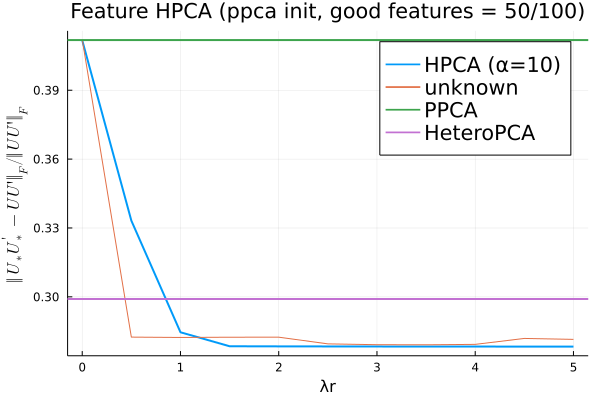

In [218]:
using LaTeXStrings
colors = theme_palette(:auto).colors
plot(λr, error_hpca, label="HPCA (α=10)", title="Feature HPCA (ppca init, good features = 50/100)", xlabel="λr", ylabel=L"\Vert U_{*} U_{*}^{'}- UU' \Vert_F/ \Vert UU' \Vert_F",linewidth=2, legendfontsize=14.0)
plot!(λr, error_hpca_unknown, label="unknown")
#hline!([error_wpca], label="WPCA", linewidth=2)
hline!([error_homoppca], label="PPCA", linewidth=2)
hline!([error_heteropca], label="HeteroPCA", linewidth=2)
#hline!([error_heppcat], label="HePPCAT",linewidth=2)
#annotate!(0.3, 0.695, "r=14", colors[1])
#annotate!(0.75, 0.72, "r=9", colors[1])
#annotate!(1, error_homoppca-0.01, "PPCA", colors[4])
#annotate!(2.25, error_wpca-0.01, "WPCA", :green)
#annotate!(2.25, error_heppcat+0.01, "HePPCAT", colors[5])
#savefig("HPCA_KNOWN_BAD_DATA.pdf")

In [188]:
error_homoppca

0.4118585482513651

In [190]:
error_hpca[end]

0.278332481411708

In [198]:
minimum(eigen(Y*Y').values)

877.1878935771489